# Exercise 1 - Gaussian Processes
## 1


In [1]:
from pylab import *
from numpy import *

close('all')
#  q1
def kernel(x1, x2, theta):
    """
    Code for equation 3
    """
    sigma = np.zeros((len(x1), len(x2)))
    for idx, i in enumerate(x1):
        for jdx, j in enumerate(x2):
            sigma[ idx, jdx ] = \
                theta[ 0 ] * np.exp(- .5 * theta[ 1 ] * np.sqrt((i - j)**2)) + \
                theta[ 2 ] + theta[ 3 ] * i * j
    return sigma

# 2

In [2]:
#q2
theta = ones(4)
N = 101
x = linspace(-1,1, N)
K = kernel(x, x, theta)

# 3

The Gramm matrix would be 101x101, i.e. showing the variance of the dataspace. In order to show that a matrix is semipositive definite we need to show that all eigenvalues are non-negative, $\lambda_i \geq 0$

In [3]:
print('Shape of K', K.shape)
eigenValues, eigenVectors = linalg.eig(K)

print(r'eigenvalues greater than zero?', all(eigenValues >= 0))

Shape of K (101, 101)
eigenvalues greater than zero? True


# 4

Note: numpy yields an error message, stating that the Gramm matrix is not semipositive definite.
We think this is due to what is mentioned in question 3; the values are sometimes negative, and all have a complex part. However, these are so tiny (near machine error) they can be considered zero.

As $K$ is singular, we had to parse allow_singular to the multivariate object from scipy.

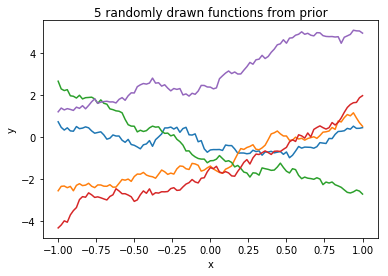

In [4]:
# q4
from scipy.stats import multivariate_normal as mv
mu = zeros(len(x))
prior = mv(mu, K)
samples = prior.rvs(5)

fig, ax = subplots(1, 1)
for i in samples:
    ax.plot(x, i)
savefig('../Figures/ex1q5')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('5 randomly drawn functions from prior')
show()

# 5

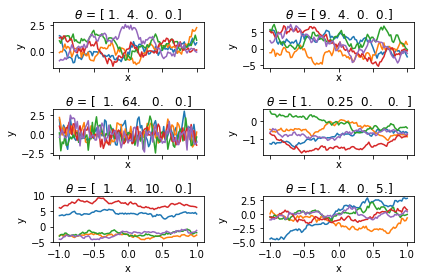

In [5]:
# q5
thetas = np.array([ [ 1, 4, 0, 0 ], [ 9, 4, 0, 0 ], [ 1, 64, 0, 0 ],
                    [ 1, 0.25, 0, 0 ], [ 1, 4, 10, 0 ], [ 1, 4, 0, 5 ] ])

# we want at most 3 rows
nRows = 3
# get the the number of columns
nCols = thetas.shape[ 0 ] // nRows

# plot the prior for different theta
fig, ax = subplots(nrows=nRows, ncols=nCols, sharex='all')
for idx, thetai in enumerate(thetas):
    # compute the Gramm matrix
    K = kernel(x, x, thetai)
    # generate prior object
    prior = mv(mu, K, allow_singular=1)
    # sample from the prior
    samples = prior.rvs(5)
    for i in samples:
        ax.flatten()[ idx ].plot(x, i)
    ax.flatten() [ idx ].set_title(r'$\theta$ = {0}'.format(thetai))
    ax.flatten() [ idx ].set_xlabel('x')
    ax.flatten() [ idx ].set_ylabel('y')
fig.tight_layout()
savefig('../Figures/ex1q5.png')
show()

# Bonus explanation

# 6

In computing C we will use equation 6.62 from Bisschop.

C:
  [[ 3.25        1.60468809  1.52032005  1.86873075]
 [ 1.60468809  3.04        2.01122942  1.84070798]
 [ 1.52032005  2.01122942  3.09        1.78873075]
 [ 1.86873075  1.84070798  1.78873075  3.01      ]]


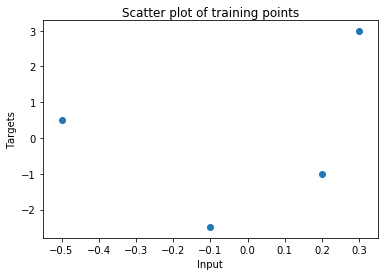

In [6]:
# q6
xTrain = array([[-.5, .2, .3 , -.1]]).T
tTrain = array([[.5, -1, 3, -2.5]]).T
KTrain = kernel(xTrain, xTrain, theta)
beta   = 1
C      = KTrain + 1/beta * eye(len(xTrain))
print('C:\n ',C)

fig, ax = subplots()
ax.scatter(xTrain, tTrain)
ax.set_title('Scatter plot of training points')
ax.set_ylabel('Targets')
ax.set_xlabel('Input')
show()


# 7

In order to compute the $\mu$ at x = 0, we will to compute the Gramm matrix 
using the training points and the new point (see Bisschop p.307); i.e. we compute
    *K* = K($\boldsymbol{X_n}, \boldsymbol{X_{N+1}}$), where $\boldsymbol{X_n}$ is the set
    $i = 1,...,N$ and $X_{N+1} = 0$.

In [15]:
xNew       = array([[0]])
xTrainNew  = vstack((xTrain, xNew))
c          = kernel(xNew, xNew, theta) + 1/beta
k          = kernel(xTrain, xNew, theta)
invC       = linalg.inv(C)
# Bisschop 6.66
mu_new     = k.T.dot(invC).dot(tTrain)
# Bisschop 6.67
sigma_new  = c - k.T.dot(invC).dot(k)
print('mu at x = {0}:\n{1}'.format(xNew[0], mu_new) )
print('sigma^2 at x = {0}:\n{1}'.format(xNew[0], sigma_new) )



mu at x = [0]:
[[-0.20721389]]
sigma^2 at x = [0]:
[[ 1.32520089]]


# 8 

Do we need to take a new data point x to infinity or the training set?
If it is the former, then no it will not go to zero as the mean and variance of the predictive distribution is dependent on the
datapoints seen. We would need to change the last part ($x^T x$) to zero in order to not blow the mean up. Since the exponent of the gaussian will got towards zero for large values, hence we would need to supress the covariance (last term). Yet still the covariance and mean are dependent on the datapoints seen thus it will never go to zero for the same trainingset.  We will show this in python:

In [16]:
# take a very large number
xNew       = array([[1e30]])
xTrainNew  = vstack((xTrain, xNew))
c          = kernel(xNew, xNew, theta) + 1/beta
thetaEdit  = theta.copy(); thetaEdit[-1] = 0
k          = kernel(xTrain, xNew, thetaEdit)
invC       = linalg.inv(C)
# Bisschop 6.66
mu_new     = k.T.dot(invC).dot(tTrain)
# Bisschop 6.67
sigma_new  = c - k.T.dot(invC).dot(k)
print('mu at x = {0}:\n{1}'.format(xNew[0], mu_new) )
print('sigma^2 at x = {0}:\n{1}'.format(xNew[0], sigma_new) )

mu at x = [  1.00000000e+30]:
[[ 0.05073655]]
sigma^2 at x = [  1.00000000e+30]:
[[  1.00000000e+60]]
